<style type="text/css">
    .align-center {text-align: center; margin: auto;}
    h1 {
      color: #D41212;
      font-family: Impact;
      font-weight: bold;
      font-size: 280%;
      text-align: center;
      text-transform: uppercase;
    }
    h2 {
      color: #11A6D9;
      font-family: Tahoma;
      font-size: 230%;
    }
    h3 {
      color: #14D65F;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 1.5em;
    }
    h4 {
      color: #FBC623;
      font-family: Verdana;
      font-size: 160%;
      margin-left: 3em;
    }
</style>
<body style = "text-align:justify">

<div class="align-center">
  <img src="https://minas.medellin.unal.edu.co/images/Escudo_color.png" title="UNAL" alt="UNAL" width="400">
</div>

#### Autor

  + [Jeison Mauricio Alarcón Becerra](https://jeison-alarcon.netlify.app/)

___
___

___
___
# **SENTIMENT ANALYSIS WITH 1.6 MILLION TWEETS**

<center>
  <img src = "https://www.kdnuggets.com/images/sentiment-fig-1-689.jpg"
       alt    = "Sentiment Analysis."
       height = "360"
       title  = "Sentiment Analysis .">
</center>

___
___

## *Paquetes y Librerías*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import tensorflow as tf
print("Versión de Tensorflow = ", tf.__version__)
# import warnings
# warnings.filterwarnings("ignore")

Versión de Tensorflow =  2.5.0


___
## *Lectura y Tratamiento de los Datos*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

tweets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA/Training1.6M_ProcessedNoEmoticon.csv",
                     encoding = "latin", names = ["Sentiment", "ID", "Date", "Query", "User", "Tweet"])
tweets.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Sentiment,ID,Date,Query,User,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Eliminando las columnas innecesarias para el análisis
tweets.drop(["ID", "Date", "Query", "User",], axis = 1, inplace = True)
tweets.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Verificando si existen valores faltantes
(tweets.isnull().sum() / len(tweets))*100

Sentiment    0.0
Tweet        0.0
dtype: float64

In [5]:
# Revolvemos las filas del dataset
tweets = tweets.sample(frac = 1)
# Para que el procesamiento sea más rápido
tweets = tweets[:100000]
# Valores únicos de la variable sentimiento
#   ■ Actualmente (0 = Negativo, 4 = Positivo)
tweets["Sentiment"].unique()

array([0, 4])

> Cambiando la codificación a $(0 := \texttt{Negative}, 1 := \texttt{Positive})$, por cuestiones de interpretabilidad.

In [6]:
tweets["Sentiment"] = tweets["Sentiment"].replace(4, 1)

In [7]:
# Convirtiendo el objeto pandas en string
tweets["Tweet"] = tweets["Tweet"].astype("str")

In [8]:
# Verificando la cantidad de tweets etiquetados como positivos vs negativos
Positivos = tweets["Sentiment"][tweets.Sentiment==1]
Negativos = tweets["Sentiment"][tweets.Sentiment==0]

print("La longitud total de los datos es:           {}".format(tweets.shape[0]),
      "No. de oraciones etiquetadas como positivas: {}".format(len(Positivos)),
      "No. de oraciones etiquetadas como negativas: {}".format(len(Negativos)),
      sep = "\n"
     )

La longitud total de los datos es:           100000
No. de oraciones etiquetadas como positivas: 49895
No. de oraciones etiquetadas como negativas: 50105


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


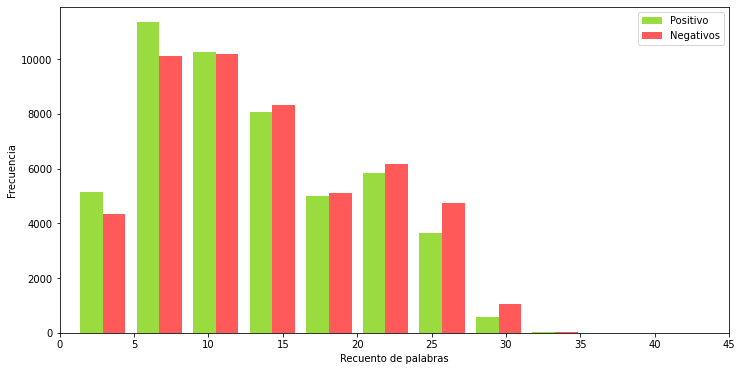

In [9]:
# Obteniendo un recuento de las palabras por tweet
def word_count(words):
  return len(words.split())
# Graficando la distribución del recuento de palabras tanto para el sentimiento positivo como negativo
Temp = tweets.copy()
Temp["Word_Count"] = Temp["Tweet"].apply(word_count)
Pos = Temp["Word_Count"][tweets.Sentiment==1]
Neg = Temp["Word_Count"][tweets.Sentiment==0]

plt.figure(figsize = (12, 6))
plt.xlim(0, 45)
plt.xlabel("Recuento de palabras"); plt.ylabel("Frecuencia")
g = plt.hist([Pos, Neg], color = ["#81D20F", "#FF2F2F"], alpha = 0.8, label = ["Positivo", "Negativos"])
plt.legend(loc = "upper right")

del Temp, Pos, Neg

___
## *Preliminares Indispensables*

> Stop Words: Una Stop Word es una palabra de uso común (como "el", "a", "una", "en") que un motor de búsqueda ha sido programado para ignorar, tanto al indexar entradas para buscarlas como al recuperarlas. Como resultado de una consulta de búsqueda.

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords"), nltk.download("punkt"), nltk.download("wordnet")
StopWords = set(stopwords.words("english"))
print(StopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
{'too', 'yourself', 'their', 'between', 'below', 'after', 've', 'myself', 'were', 'own', "you've", 'more', 'himself', 'then', 'both', 'we', 'ours', 'is', 'have', 'nor', 'who', "won't", 'i', 'for', 'up', 'shan', 'while', 'under', 'all', 'by', 't', 's', 'here', 'where', 'this', 'theirs', 'are', 'into', "hasn't", "haven't", 'those', 're', 'each', 'being', 'most', 'few', "isn't", 'through', 'such', 'should', 'doesn', 'an', "wouldn't", 'themselves', 'wouldn', "doesn't", 'these', 'very', 'they', 'because', 'our', 'whom', 'hers', 'his', "didn't", 'me', "she's", 'having', 'why', 'that', 'o', 'other', 'about', 'ain', 'mustn', 'aren', 'weren', 'during', 'will', "you'll"

### Limpieza de los datos

In [11]:
import re
import string
import pickle
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/MINERÍA DE DATOS")
from Twitter_Functions import *

URLs_Pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
User_Pattern = "@[^\s]+"
Otras = "amp,today,tomorrow,going,girl"
def ProcesarTweets(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = tweet.lower()
    tweet=tweet[1:]

    # Removiendo todas las URLs
    tweet = re.sub(pattern = URLs_Pattern, repl = '', string = tweet)
    # Removiendo todas los @username
    tweet = re.sub(pattern = User_Pattern, repl = '', string = tweet)
    # Removiendo algunas otras palabras
    tweet = re.sub(pattern = Otras, repl = '', string = tweet)
    # Eliminando los signos de puntuación
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    # Tokenización de las palabras
    tokens = word_tokenize(tweet)
    #tokens = [w for w in tokens if len(w)>2]
    # Eliminando las Stop Words
    final_tokens = [w for w in tokens if w not in StopWords]
    # Reduciendo las palabras a su raíz
    wordLemm = WordNetLemmatizer()
    finalwords = []
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [12]:
# Procesamiento de texto completo
tweets["processed_tweets"] = tweets["Tweet"].apply(lambda x: ProcesarTweets(x))
tweets["processed_tweets"] = tweets["processed_tweets"].apply(lambda x: Abbrev2Text(x))
print("» Procesamiento previo del texto completado.")
tweets

» Procesamiento previo del texto completado.


,Sentiment,Tweet,processed_tweets
96529,0,@TerrenceJ106 let's see if this actually works...,terrencej106 let you see actually work trying ...
10114,0,"@teddpatt aww, not in Hudson today in the city...",teddpatt aww hudson today city another two week
756775,0,@backgotback I wish I am still very broke. Th...,backgotback wish still broke travel forseable ...
34813,0,good mornin.... my eyes r so red idk y....,ood mornin eye red i do not know
249026,0,Still getting about 34% packet loss. Phone nu...,till getting 34 packet loss phone number dsl c...
...,...,...,...
962556,1,"@julesyog Oh Cool, I will be over in a minute ...",julesyog oh cool minute
1224181,1,Heading to work hope it goes by fast,eading work hope go fast
247261,0,"@ReaganGomez damn, sorry to hear that",reagangomez damn sorry hear
188967,0,when I'm sick i pretend to be a little owl. ho...,hen sick pretend little owl hoot hoot


In [13]:
# Eliminando las palabras cortas (shortwords)
tweets["processed_tweets"] = tweets["processed_tweets"].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
tweets.head()

,Sentiment,Tweet,processed_tweets
96529,0,@TerrenceJ106 let's see if this actually works...,terrencej106 actually work trying send longest...
10114,0,"@teddpatt aww, not in Hudson today in the city...",teddpatt hudson today city another week
756775,0,@backgotback I wish I am still very broke. Th...,backgotback wish still broke travel forseable ...
34813,0,good mornin.... my eyes r so red idk y....,mornin know
249026,0,Still getting about 34% packet loss. Phone nu...,till getting packet loss phone number changing...


### Análisis descriptivo

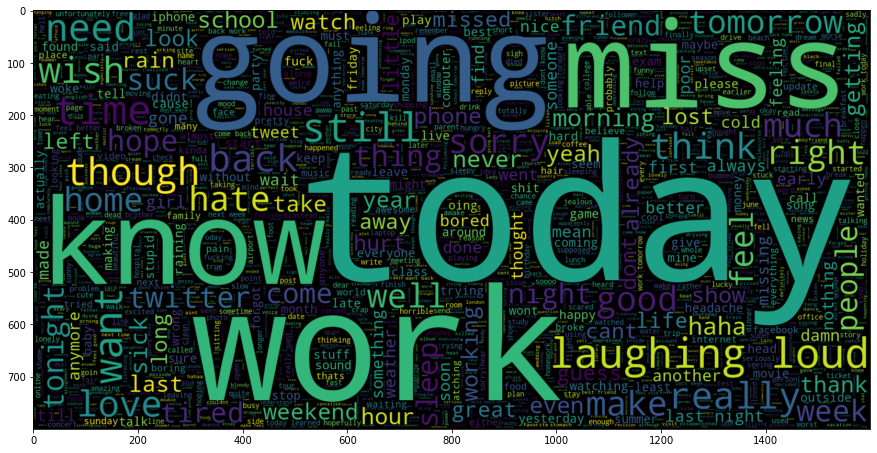

In [14]:
# Nube de palabras para los tweets negativos
plt.figure(figsize = (15, 15))
WC = WordCloud(width = 1600, height = 800, max_words = 2000).generate(" ".join(tweets[tweets.Sentiment==0].processed_tweets))
plt.imshow(WC, interpolation = "bilinear")

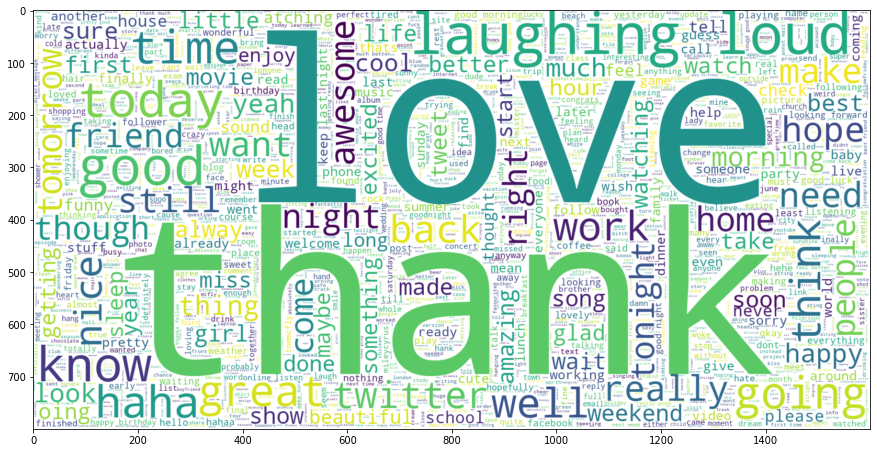

In [15]:
# Nube de palabras para los tweets positivos
plt.figure(figsize = (15, 15))
WC = WordCloud(width = 1600, height = 800, max_words = 2000, background_color = "white").generate(" ".join(tweets[tweets.Sentiment==1].processed_tweets))
plt.imshow(WC, interpolation = "bilinear")

In [16]:
# Barajando los registros de nuevo
from sklearn.utils import shuffle
tweets = shuffle(tweets).reset_index(drop = True)

# tweets.to_csv("/content/drive/MyDrive/Colab Notebooks/DATA/Training1.6M_ProcessedNoEmoticon_Cleaned.csv", index = False)

### TF-IDF

Este es un acrónimo que significa **Term Frequency - Inverse Document**, que son los componentes de las puntuaciones resultantes asignadas a cada palabra.

  + *Frecuencia de términos*: resume la frecuencia con la que aparece una palabra determinada en un documento.
  + *Frecuencia inversa del documento*: esto reduce la escala de las palabras que aparecen mucho en los documentos.

In [17]:
# Convirtiendo la colección de documentos sin procesar en una matriz de funciones TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vector   = TfidfVectorizer(sublinear_tf = True)
X_TF_IDF = vector.fit_transform(tweets["processed_tweets"].values)

print("» Vector Ajustado.",
      "No. de palabras destacadas {}".format(len(vector.get_feature_names())),
      "Dimensionalidad de X = {}, y = {}".format(X_TF_IDF.shape, tweets["Sentiment"].shape),
      sep = "\n"
      )

» Vector Ajustado.
No. de palabras destacadas 96723
Dimensionalidad de X = (100000, 96723), y = (100000,)


### Tokenización

In [18]:
tokenized_tweet = tweets["processed_tweets"].apply(lambda x: x.split())
tokenized_tweet.head()

0    [alyb, downloaded, work, laughing, loud, wooot...
1    [thehillers, cartoon, version, amusing, kidshu...
2    [razorianfly, following, feed, pound, hope, well]
3                   [beewentz, wait, comming, morning]
4                      [djheather, ever, make, rained]
Name: processed_tweets, dtype: object

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r"[a-zA-Z0-9]+")
cv = CountVectorizer(stop_words = "english", ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv.fit_transform(tweets["processed_tweets"].values.astype("U"))

X_Token = text_counts

### División del conjunto de entrenamiento y de prueba

In [20]:
X = X_TF_IDF # ó X_Token
y = tweets["Sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021)

### Función de evaluación del modelo

In [21]:
from Personal_Functions import *

___
## $\texttt{Modelo Logístico}$

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 83.175%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 73.620%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      9918
           1       0.73      0.76      0.74     10082

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



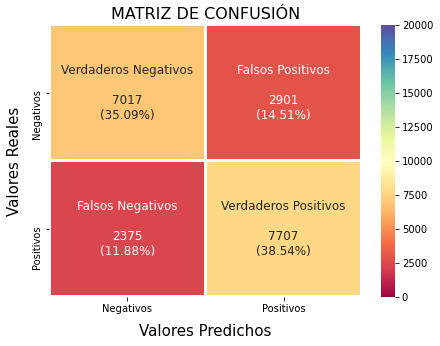

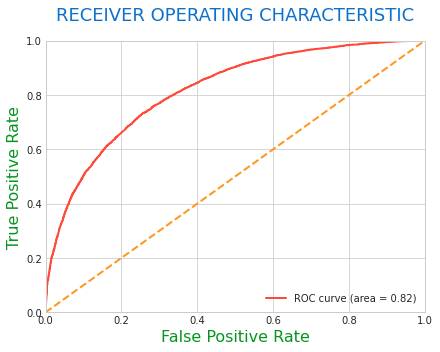

In [23]:
from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression(max_iter = 500)
Logistic.fit(X_train, y_train)

ModelEvaluate(Logistic)

___
## $\texttt{Linear SVM}$

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 93.603%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 72.420%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      9918
           1       0.72      0.74      0.73     10082

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



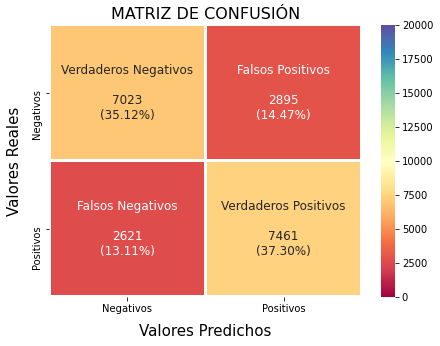

In [24]:
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(X_train, y_train)

ModelEvaluate(SVM, ROC = False)

___
## $\texttt{Random Forest}$

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 76.409%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 70.210%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      9918
           1       0.68      0.76      0.72     10082

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



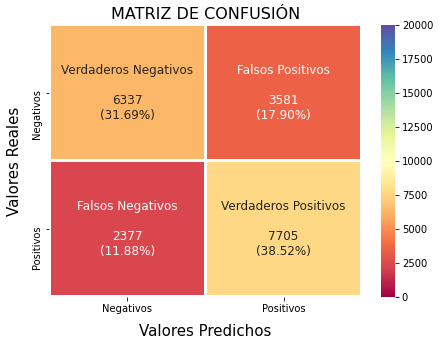

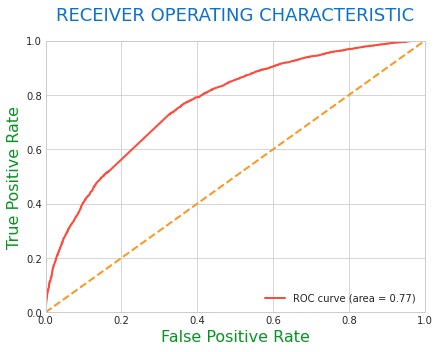

In [25]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 30, criterion = "entropy", max_depth = 50)
RF.fit(X_train, y_train)

ModelEvaluate(RF)

___
## $\texttt{Naive Bayes}$

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 87.115%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 72.600%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      9918
           1       0.74      0.70      0.72     10082

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



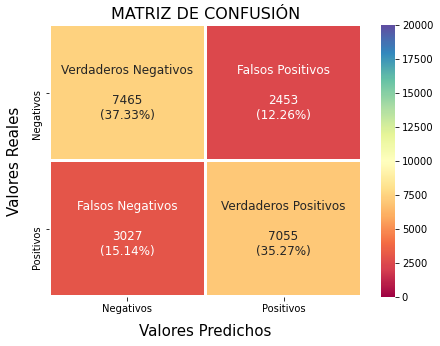

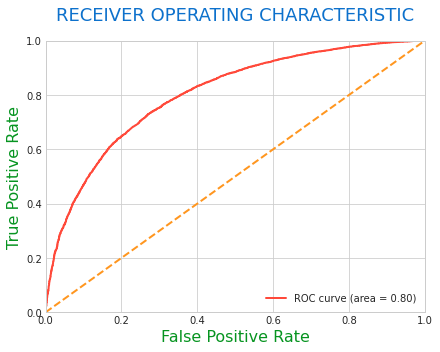

In [26]:
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB()
NB.fit(X_train, y_train)

ModelEvaluate(NB)

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 87.757%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 72.220%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      9918
           1       0.75      0.67      0.71     10082

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



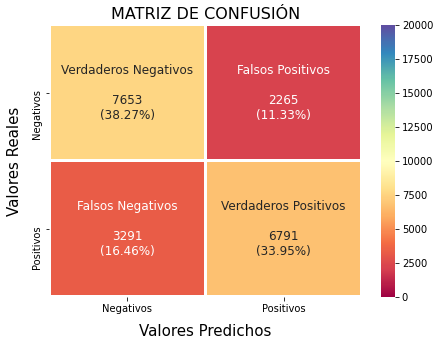

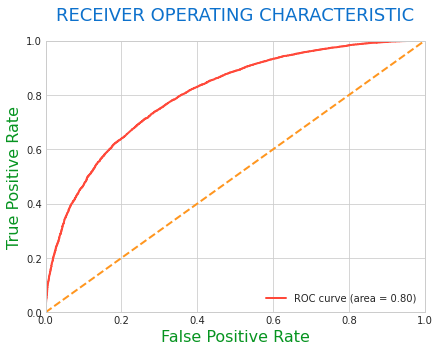

Puntuación de validación cruzada = [0.7247  0.72145 0.7222  0.7208  0.7269 ]


In [27]:
from sklearn.naive_bayes import ComplementNB
CNB = ComplementNB()
CNB.fit(X_train, y_train)

ModelEvaluate(CNB)
CrossVal_CNB  = cross_val_score(CNB, X, y, n_jobs = -1)
print("Puntuación de validación cruzada = {}".format(CrossVal_CNB))

___
## $\texttt{RNN}$

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

MaxWords = 5000; MaxLen = 200
tokenizer = Tokenizer(num_words = MaxWords)
tokenizer.fit_on_texts(tweets.processed_tweets)
sequences = tokenizer.texts_to_sequences(tweets.processed_tweets)

Tweets = pad_sequences(sequences, maxlen = MaxLen)
print(Tweets)

[[   0    0    0 ...   10   59    6]
 [   0    0    0 ...  659 3758  273]
 [   0    0    0 ... 1072   27   19]
 ...
 [   0    0    0 ... 1464    4   67]
 [   0    0    0 ...    0    0  466]
 [   0    0    0 ...    0    0    0]]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(Tweets, y, test_size = 0.2, random_state = 2021)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

RNN = Sequential()
RNN.add(Embedding(MaxWords, 128))
RNN.add(LSTM(64, dropout = 0.5))
RNN.add(Dense(16, activation = "relu"))
RNN.add(Dense(8, activation = "relu"))
RNN.add(Dense(1, activation = "sigmoid"))

RNN.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
History = RNN.fit(X_train, y_train, epochs = 1, validation_data = (X_test, y_test))

2500/2500 [==============================] - 350s 132ms/step - loss: 0.5884 - accuracy: 0.6757 - val_loss: 0.5264 - val_accuracy: 0.7323


In [31]:
def Sentimiento(modelo, frase, maxlen):
  Frase = tokenizer.texts_to_sequences([frase])
  Prediccion = modelo.predict(pad_sequences(Frase, maxlen = maxlen))
  if Prediccion > 0.5: x = "Positivo"
  else : x = "Negativo"
  print("■ ", frase, ", se predice que hace referencia a un sentimiento »» ", x, sep = "")

Sentimiento(RNN, "this data science article is the worst ever", MaxLen)
Sentimiento(RNN, "this data science article is the best ever", MaxLen)
Sentimiento(RNN, "I had a bad day at work", MaxLen)

■ this data science article is the worst ever, se predice que hace referencia a un sentimiento »» Negativo
■ this data science article is the best ever, se predice que hace referencia a un sentimiento »» Positivo
■ I had a bad day at work, se predice que hace referencia a un sentimiento »» Negativo


In [32]:
# https://www.kaggle.com/smitshah00/sentiment-analysis-ml-rnn
# https://www.kaggle.com/akashbhakat/sin-project-twitter-sentiment-analysis-using-nn


# Teoria full -> https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained y https://www.kaggle.com/muhammadimran112233/eda-twitter-sentiment-analysis-using-nn
# 

|     Modelo    | Accuracy (%) |
|:-------------:|:------------:|
|   Logístico   |    73.630    |
|      SVM      |    72.420    |
| Random Forest |    70.210    |
|  Naive Bayes  |    72.600    |
|      RNN      |    73.230    |

___
___
# **TWITTER US AIRLINE SENTIMENT**

<center>
  <img src = "https://image.slidesharecdn.com/capstoneprojectgadatasciencelinm-160512021206/95/sentiment-analysis-of-airline-tweets-1-638.jpg"
       alt    = "Sentiment Analysis of Airline Tweets."
       height = "360"
       title  = "Sentiment Analysis of Airline Tweets .">
</center>

Los datos provienen originalmente de la biblioteca *Data for Everyone de Crowdflower*. En el cual se realizó un trabajo de análisis de sentimientos sobre los problemas de cada una de las principales aerolíneas de EE. UU. Los datos de Twitter se extrajeron de febrero de $2015$ y se pidió a los colaboradores que primero clasificaran los tweets positivos, negativos y neutrales, seguidos de categorizar las razones negativas (*como "retraso en el vuelo" o "servicio grosero"*).

___
___

___
## *Lectura y Tratamiento de los Datos*

In [33]:
from google.colab import drive
drive.mount('/content/drive')

tweets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA/Tweets.csv", encoding = "latin")
tweets.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [34]:
# Eliminando las columnas innecesarias para el análisis
tweets.drop("tweet_id", axis = 1, inplace = True)

In [35]:
# Imputando los valores faltantes en las columnas restantes
from sklearn.impute import KNNImputer

Columns = ["negativereason", "negativereason_gold", "airline_sentiment_gold", "tweet_location", "tweet_coord", "user_timezone"]
for i in Columns:
  tweets[i].fillna("unknown", inplace = True)

Imputer = KNNImputer(missing_values = float, n_neighbors = 5, metric = "nan_euclidian", weights = "uniform")
tweets["negativereason_confidence"].fillna(0, inplace = True)
tweets["negativereason_confidence"] = Imputer.fit_transform(tweets[["negativereason_confidence"]])

tweets["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [36]:
tweets.isnull().sum()

airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

___
## *Preliminares Indispensables*

### Análisis descriptivo

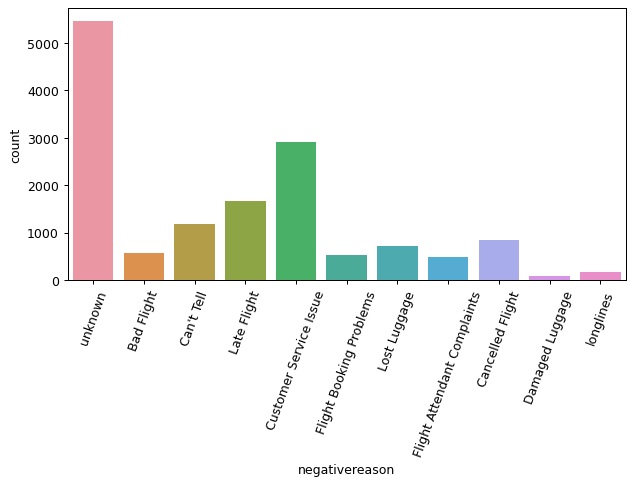

In [37]:
# ■ De acuerdo con la siguiente gráfica el tipo de servicio negativo es un problema de servicio al cliente en general.
plt.figure(figsize = (8, 4), dpi = 90)
plt.xticks(rotation=70);
sns.countplot(x = "negativereason", data = tweets)

In [38]:
tweets.groupby("airline_sentiment").describe().loc[:, (slice(None), ["count", "mean", "std", "50%"])].transpose()

airline_sentiment                      negative      neutral     positive
airline_sentiment_confidence count  9178.000000  3099.000000  2363.000000
                             mean      0.933365     0.823303     0.872039
                             std       0.138109     0.185594     0.179478
                             50%       1.000000     0.916000     1.000000
negativereason_confidence    count  9178.000000  3099.000000  2363.000000
                             mean      0.731769     0.000000     0.000000
                             std       0.238276     0.000000     0.000000
                             50%       0.680600     0.000000     0.000000
retweet_count                count  9178.000000  3099.000000  2363.000000
                             mean      0.093375     0.060987     0.069403
                             std       0.792865     0.658037     0.659914
                             50%       0.000000     0.000000     0.000000

In [39]:
# ■ Recuento del sentimiento en función de cada aerolínea.
pd.DataFrame(tweets[["airline_sentiment", "airline"]].value_counts(), columns = ["rated"])

rated
airline_sentiment airline              
negative          United           2633
                  US Airways       2263
                  American         1960
                  Southwest        1186
                  Delta             955
neutral           Delta             723
                  United            697
                  Southwest         664
positive          Southwest         570
                  Delta             544
                  United            492
neutral           American          463
                  US Airways        381
positive          American          336
                  US Airways        269
negative          Virgin America    181
neutral           Virgin America    171
positive          Virgin America    152

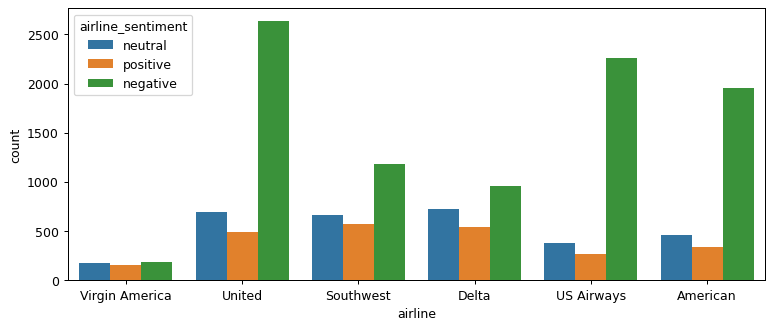

In [40]:
# ■ Se puede ver que United, Airways y American son las 3 peores aerolíneas mientras que Southwest es una de las mejores.
plt.figure(figsize = (10, 4), dpi = 90)
sns.countplot(x = "airline", hue = "airline_sentiment", data = tweets)

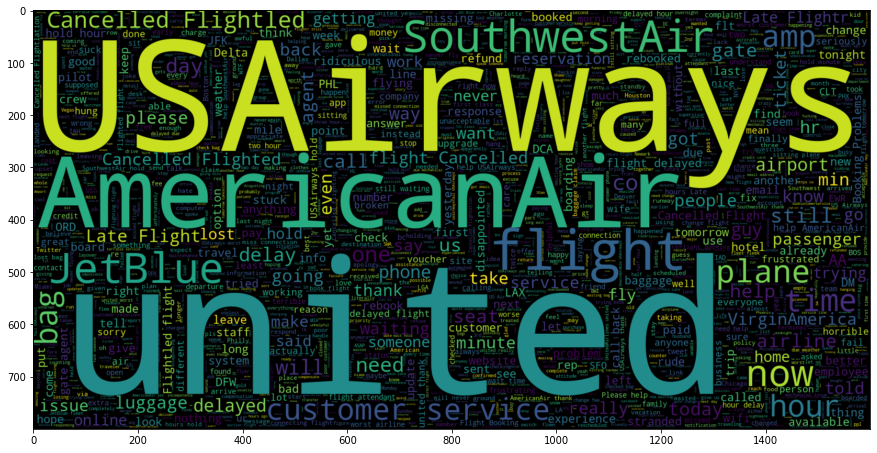

In [41]:
# Nube de palabras para los tweets negativos
plt.figure(figsize = (15, 15))
WC = WordCloud(width = 1600, height = 800, max_words = 2000).generate(" ".join(tweets[tweets["airline_sentiment"] == "negative"].text))
plt.imshow(WC, interpolation = "bilinear")

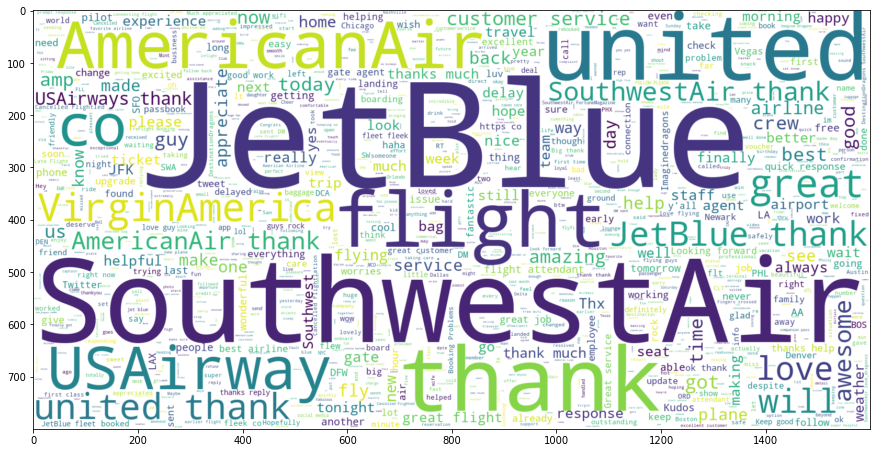

In [42]:
# Nube de palabras para los tweets positivos
plt.figure(figsize = (15, 15))
WC = WordCloud(width = 1600, height = 800, max_words = 2000, background_color = "white").generate(" ".join(tweets[tweets["airline_sentiment"] == "positive"].text))
plt.imshow(WC, interpolation = "bilinear")

### Tokenización

In [43]:
import re
import nltk
from string import punctuation

nltk.download("stopwords")
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words("english")

df = tweets[["text", "airline_sentiment"]]

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

remove_terms = list(punctuation + "0123456789")
norm_df = [[word.lower() for word in text.split() if word not in remove_terms] for text in df.text]
norm_df = [[re.sub(r'@\w+', '', word) for word in text if word not in remove_terms] for text in norm_df]    #remove mentions
norm_df = [[re.sub(r'http\S+', '', word) for word in text if word not in remove_terms] for text in norm_df] #remove links
norm_df = [' '.join(tok_sent) for tok_sent in norm_df]
norm_df = filter(None, normalize_corpus(norm_df))
norm_df = [tok_sent for tok_sent in norm_df if len(tok_sent.split()) > 2]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


___
## $\texttt{Modelo FastText}$

In [44]:
from gensim.models import FastText
tokenized_corpus = [wpt.tokenize(document) for document in norm_df]

# Set values for various parameters
feature_size = 100  # Word vector dimensionality  (embedding dim)
window_context = 30 # Context window size
min_word_count = 1  # Minimum word count
sample = 1e-3       # Downsample setting for frequent words

ft_model = FastText(tokenized_corpus, size = feature_size, 
                    window = window_context, min_count = min_word_count,
                    sample = sample, iter = 50)

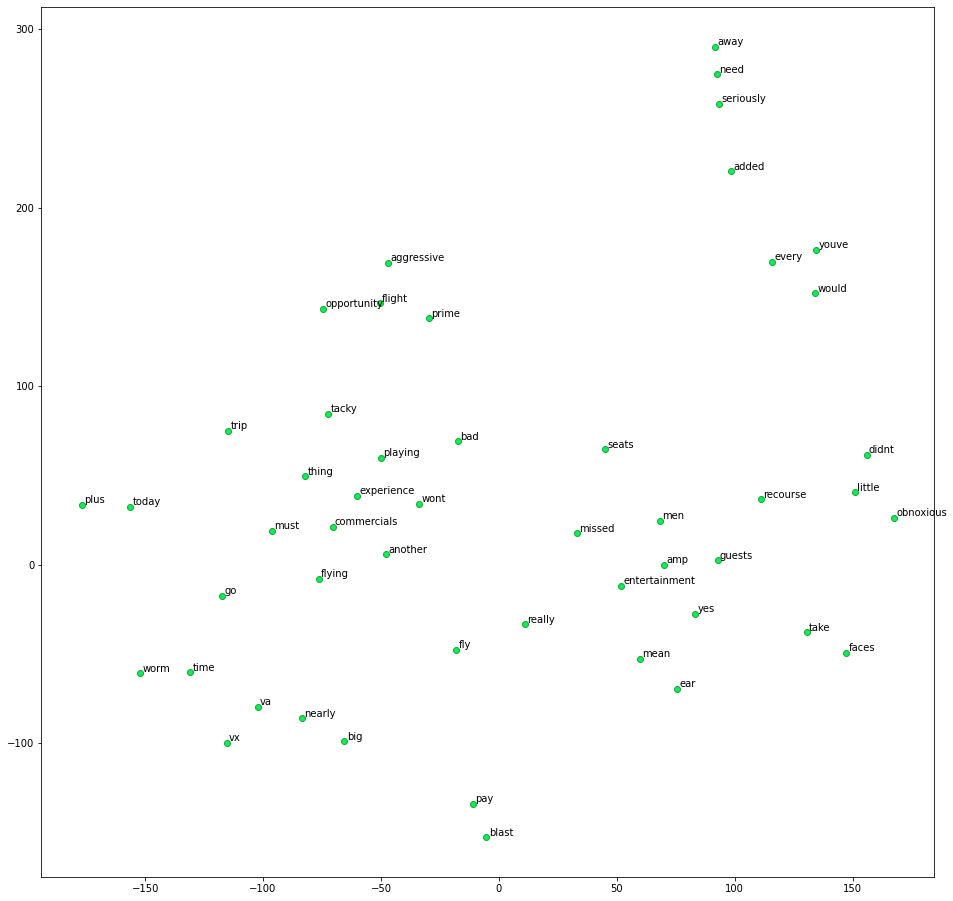

In [45]:
from sklearn.manifold import TSNE
fts = ft_model.wv[ft_model.wv.vocab]

tsne = TSNE(n_components = 2, random_state = 2021, n_iter = 10000, perplexity = 2)
np.set_printoptions(suppress = True)
T = tsne.fit_transform(fts[350:400])
labels = list(ft_model.wv.vocab.keys())

plt.figure(figsize=(16, 16))
plt.scatter(T[:, 0], T[:, 1], c = "#0CF054", edgecolors = "#1CA43E")
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy = (x+1, y+1), xytext = (0, 0), textcoords = "offset points")

### División del conjunto de entrenamiento y de prueba

In [46]:
X = tweets["text"]
y = tweets["airline_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021)

from sklearn.feature_extraction.text import TfidfVectorizer
TFID = TfidfVectorizer(stop_words = "english")
TFID.fit(X_train)

X_train_TFID = TFID.transform(X_train)
X_test_TFID  = TFID.transform(X_test)

___
## $\texttt{Modelo Logístico}$

In [48]:
from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression(max_iter = 1000)
Logistic.fit(X_train_TFID, y_train)

ModelEvaluate(Logistic)

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 87.406%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 78.279%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.81      0.93      0.87      1851
     neutral       0.67      0.47      0.55       629
    positive       0.78      0.61      0.68       448

    accuracy                           0.78      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928



___
## $\texttt{Linear SVM}$

In [49]:
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(X_train_TFID, y_train)

ModelEvaluate(SVM)

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 95.808%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 77.117%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.83      0.89      0.86      1851
     neutral       0.60      0.51      0.55       629
    positive       0.72      0.65      0.69       448

    accuracy                           0.77      2928
   macro avg       0.72      0.68      0.70      2928
weighted avg       0.76      0.77      0.76      2928



___
## $\texttt{Random Forest}$

In [50]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 30, criterion = "entropy", max_depth = 50)
RF.fit(X_train_TFID, y_train)

ModelEvaluate(RF)

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 75.470%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 69.057%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.68      0.98      0.81      1851
     neutral       0.74      0.11      0.19       629
    positive       0.79      0.29      0.42       448

    accuracy                           0.69      2928
   macro avg       0.74      0.46      0.47      2928
weighted avg       0.71      0.69      0.62      2928



___
## $\texttt{Naive Bayes}$

In [51]:
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB()
NB.fit(X_train_TFID, y_train)

ModelEvaluate(NB)

-------------------------------------------------------------------------
Precisión del Modelo en el conjunto de Entrenamiento (Training) = 81.728%
Precisión del Modelo en el conjunto de Prueba (Testing)         = 72.439%
-------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.72      0.97      0.83      1851
     neutral       0.68      0.28      0.40       629
    positive       0.82      0.33      0.47       448

    accuracy                           0.72      2928
   macro avg       0.74      0.53      0.57      2928
weighted avg       0.73      0.72      0.68      2928



|     Modelo    | Accuracy (%) |
|:-------------:|:------------:|
|   Logístico   |    78.279    |
|      SVM      |    77.117    |
| Random Forest |    69.057    |
|  Naive Bayes  |    72.439    |